### Setup

In [2]:
import os, sys
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='cobra')

from cobra import io, Model, Solution
from scripts.helpers.model import rxn_in_model, met_in_model, add_single_gene_reaction_pair
from scripts.opt._fba import flux_balance_analysis
from scripts.opt._fva import run_flux_variability_analysis

### Import Model & Preprocess

In [3]:
# Gap-filled model
model = io.read_sbml_model('../data/fill/xmls/MNL_iCre1355_auto_GAPFILL.xml')

# Add exchange reaction
ERG = "ergosterol_c"
ERGEXCH = "ERGOSTEROLEXCH"
if not rxn_in_model(model, ERGEXCH):
    add_single_gene_reaction_pair(
        model=model, 
        gene_id="EXCHERG_GENE",
        reaction_id=ERGEXCH,
        reaction_name="Ergosterol exchange (assumption)", 
        reaction_subsystem="Exchange", 
        metabolites=[(-1, ERG)],
        reversible=True
    )

No objective coefficients in model. Unclear what should be optimized


### Medium

In [4]:
# Medium metabolites
medium_mets = ["h_e","h2o_e","pi_e","nh4_e","so4_e","fe2_e","mg2_e","na1_e","photonVis_e","o2_e","co2_e"] 
medium_rxns = ['CO2th'] # CO2 transport reaction to chloroplast is additionally to be inspected

for rxn in model.reactions:

    if 'e' in rxn.compartments:

        # Ignore if a medium met is not found in rxn
        if all((not met in [x.id for x in rxn.metabolites.keys()]) for met in medium_mets):
            continue

        mets = rxn.metabolites.items()
        rs = [f'{x[0].id} ({x[0].compartment})' for x in mets if x[1] < 0],
        ps = [f'{x[0].id} ({x[0].compartment})' for x in mets if x[1] > 0]

        # Ignore sink
        if len(rs) == 0 or len(ps) == 0:
            continue

        medium_rxns.append(rxn.id)

        # print(f'{rxn.id} | {rxn.name}')
        # print(f'\tR:{rs}')
        # print(f'\tP:{ps}\n')

### Flux-Variability Analysis

In [5]:
fva = run_flux_variability_analysis(
    model,
    loopless=True,
    pfba_factor=None,
    objectives=[ERGEXCH],
    reactions=medium_rxns,
)

# fva

### Sensitivity Analysis

In [7]:
options = {
    'steps': 30,
    'significance': 0.0005
}

# Ensure there's a valid range to compute
valid_range = lambda x: fva.loc[x, 'maximum'] - fva.loc[x, 'minimum'] > options['significance']
valid_rxns = [rxn for rxn in medium_rxns if valid_range(rxn)]

# Get the range for each medium metabolite
medium_ranges = {met: (float(fva.loc[met, 'minimum']), float(fva.loc[met, 'maximum'])) for met in valid_rxns}

# CO2 is forcibly involved in the experiment
# Experimentally, we've seen that anything above 10 doesn't change the outcome
# medium_ranges['Ex_co2_e'] = (0, 10)

results = {}
for k, v in medium_ranges.items():

    print(f"Running S.A. on {k}")

    # Gradient list from minimum to maximum with 15 steps
    diff = v[1] - v[0]
    gradient = [v[0] + i * (diff / options['steps']) for i in range(options['steps'])]

    results[k] = {
        'gradient': gradient,
        'results': []
    }
    for idx, step in enumerate(gradient):
        print(f'\tStep {idx + 1}/{options["steps"]}. Value: {step:<.4f}', end='\r')
        # Copy model
        temp = model.copy()
        # Set step bounds for k
        temp.reactions.get_by_id(k).lower_bound = step
        temp.reactions.get_by_id(k).upper_bound = step
        # Run FBA
        fba = flux_balance_analysis(
            temp,
            objectives=[ERGEXCH],
            is_pfba=True
        )
        results[k]['results'].append(fba)

Running S.A. on CO2th
Running S.A. on PRISM_design_growth
Running S.A. on H2Ot78.1991
Running S.A. on NH4t9.5933
Running S.A. on O2t 0.9760
Running S.A. on SO4NA1t787
Running S.A. on SO4t9.6667
Running S.A. on FE2GTPabc80
Running S.A. on HATPase667


### Results

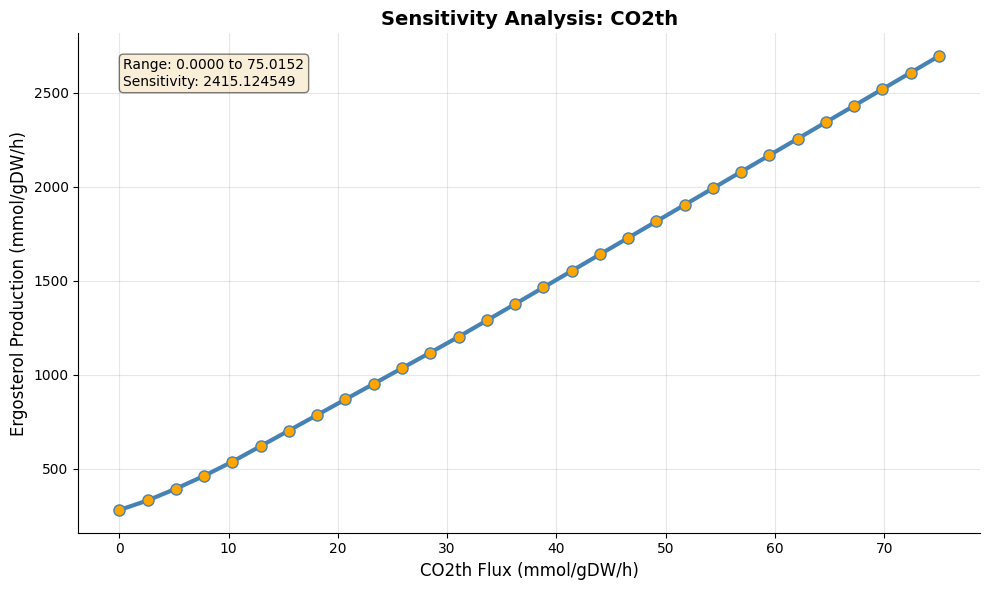

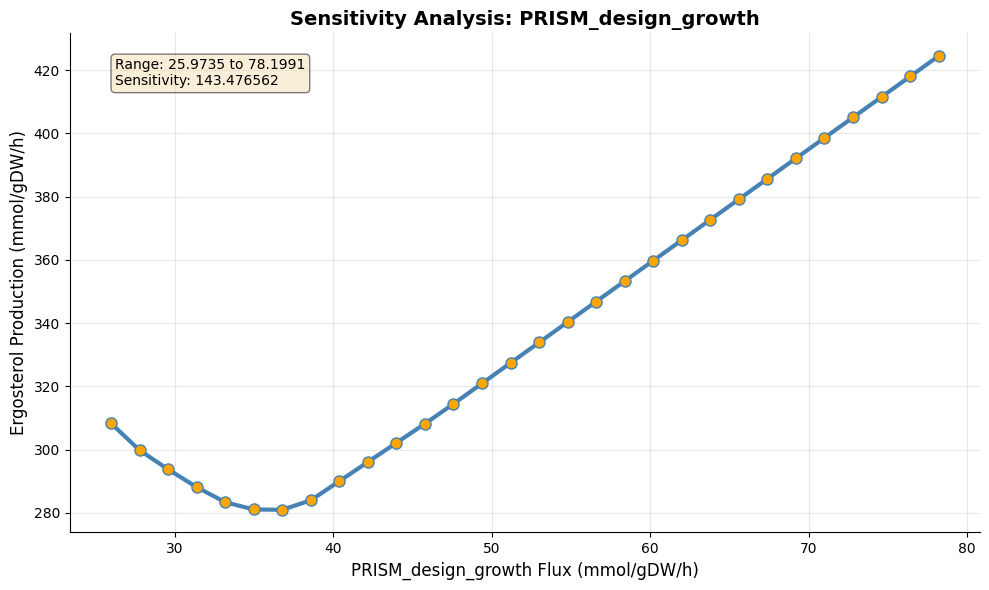

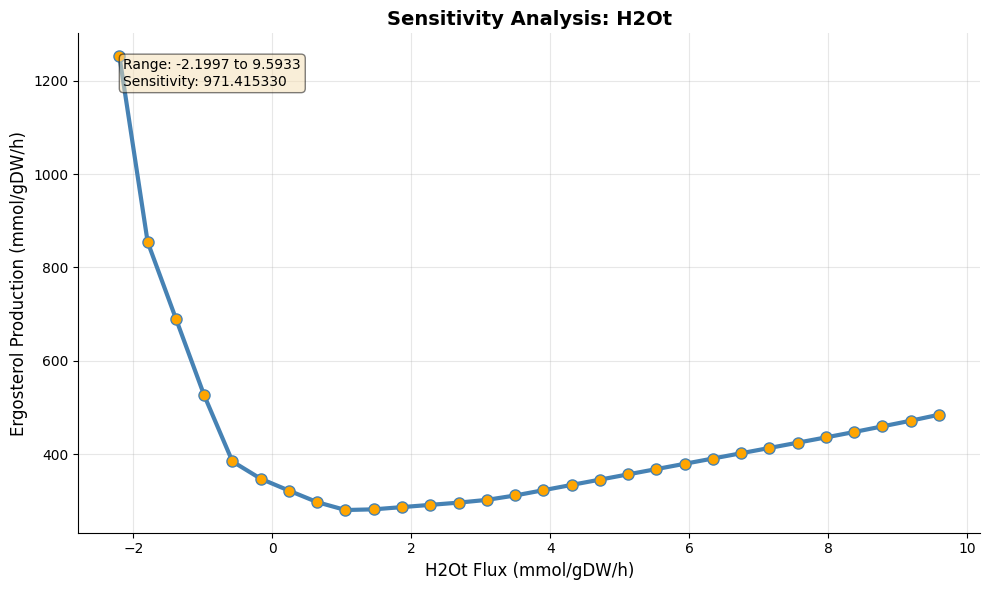

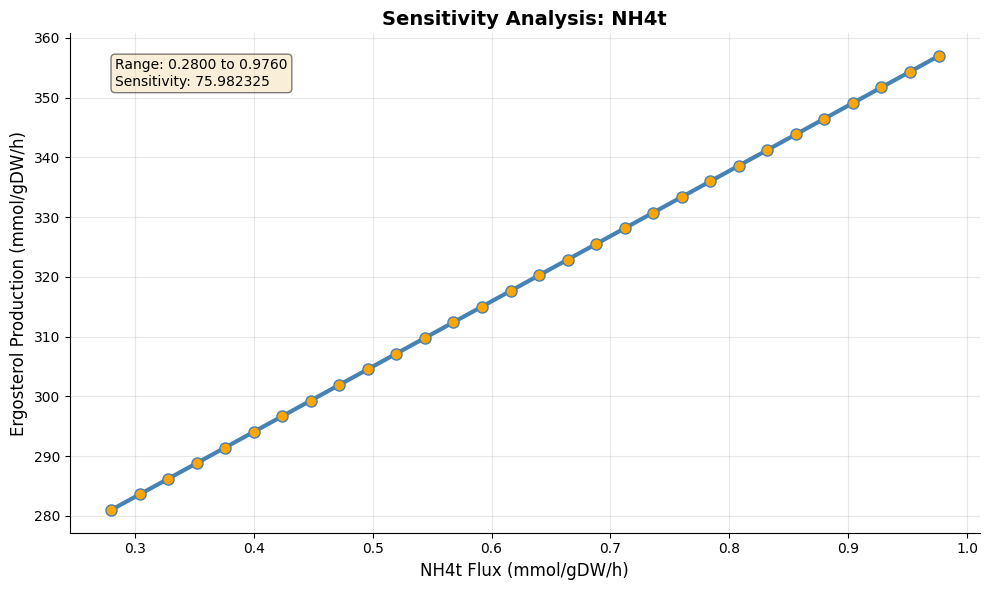

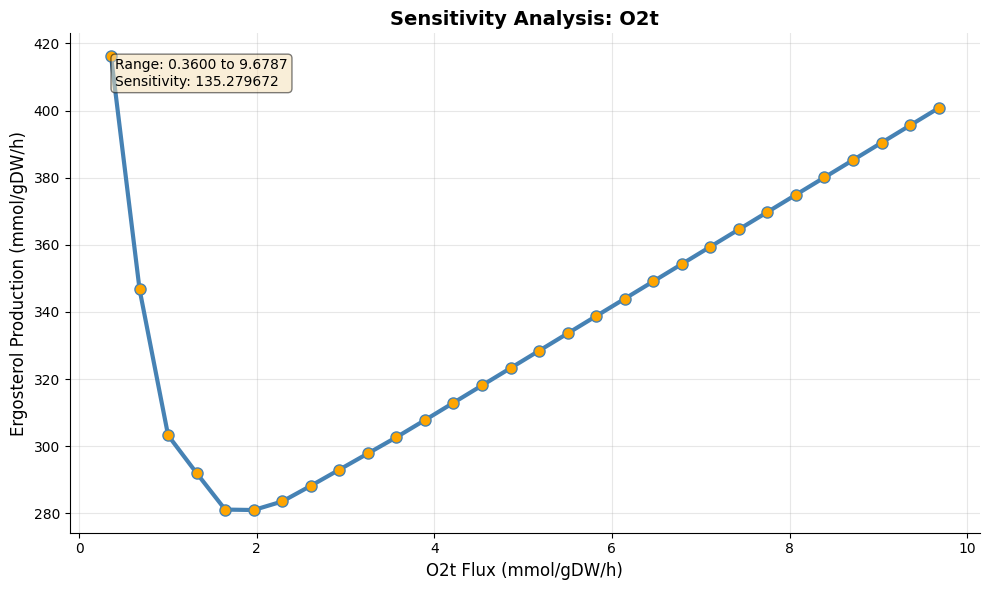

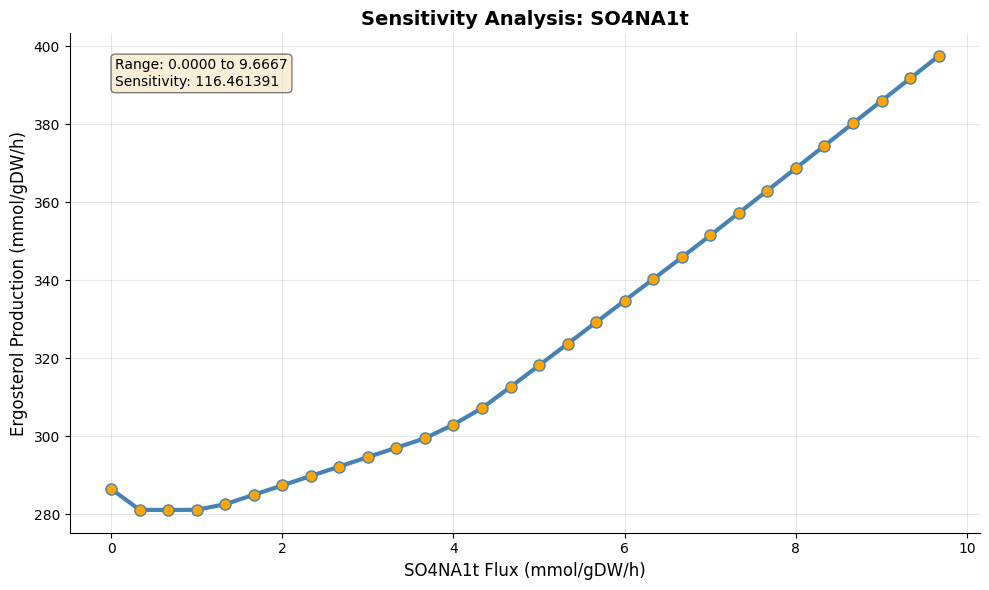

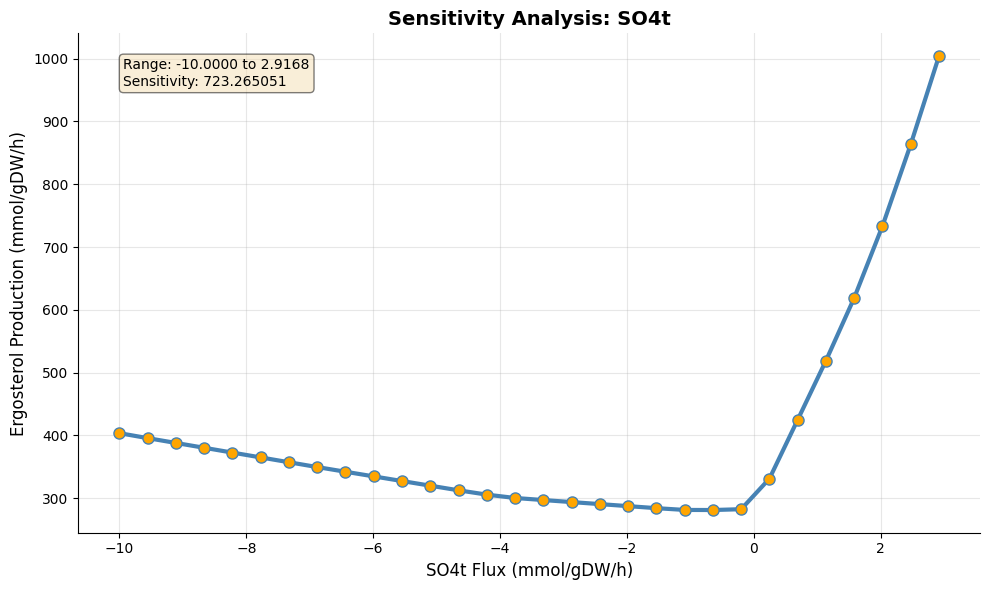

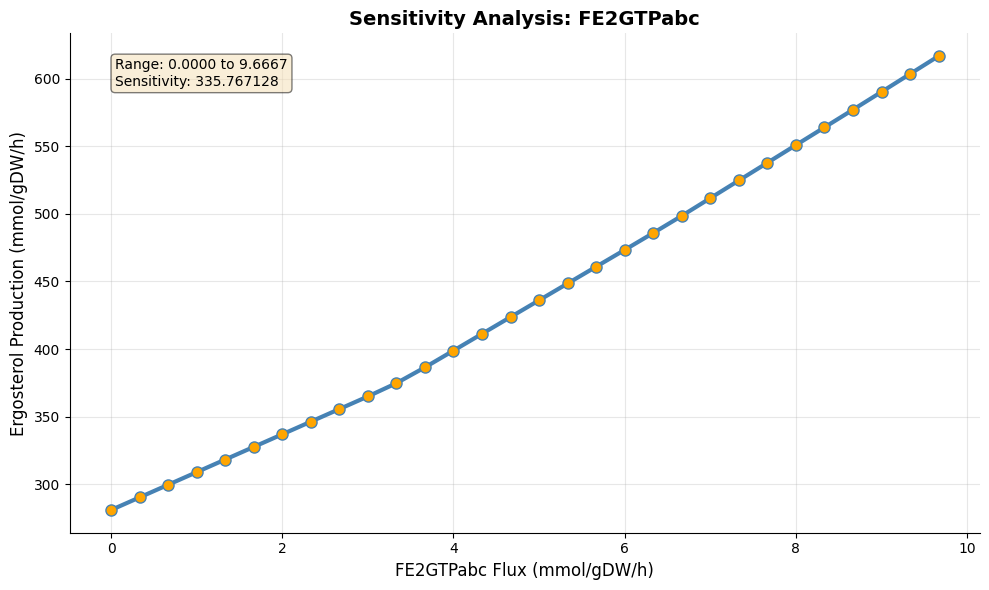

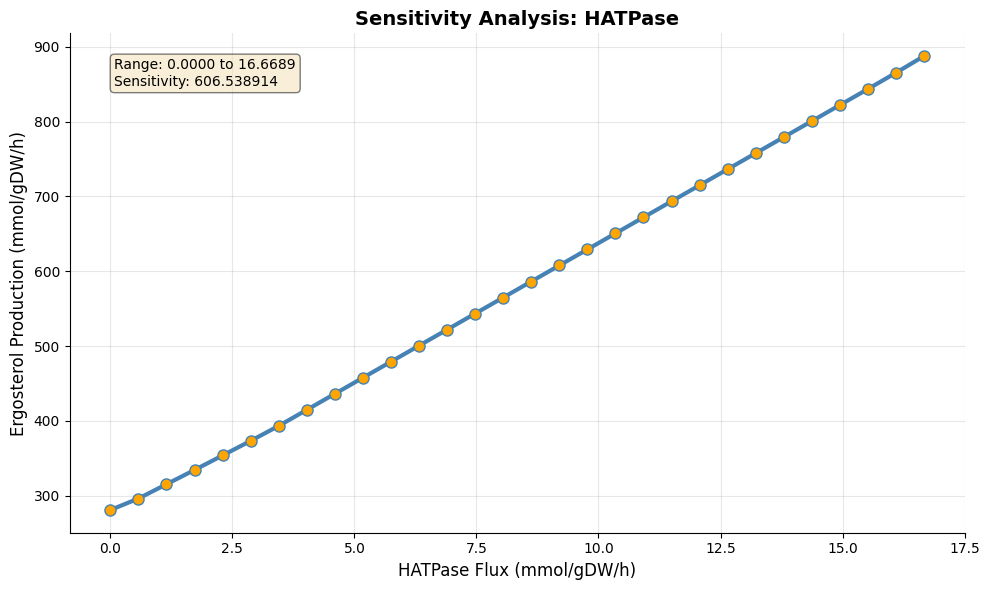

In [10]:
import matplotlib.pyplot as plt

# Individual plots for better visualization
for rxn_id, data in results.items():

    plt.figure(figsize=(10, 6))
    
    # Extract data
    gradient = data['gradient']
    objective_values = []
    
    for fba_result in data['results']:
        if fba_result is not None and hasattr(fba_result, 'objective_value'):
            objective_values.append(fba_result.objective_value)
        else:
            objective_values.append(0)
    
    # Create the plot
    plt.plot(
        gradient, objective_values, 'o-', linewidth=3, markersize=8, 
        color='steelblue', markerfacecolor='orange', markeredgecolor='steelblue'
    )
    
    # Styling
    plt.xlabel(f'{rxn_id} Flux (mmol/gDW/h)', fontsize=12)
    plt.ylabel('Ergosterol Production (mmol/gDW/h)', fontsize=12)
    plt.title(f'Sensitivity Analysis: {rxn_id}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add statistics text box
    min_obj = min(objective_values)
    max_obj = max(objective_values)
    sensitivity = max_obj - min_obj
    
    textstr = f'Range: {min(gradient):.4f} to {max(gradient):.4f}\nSensitivity: {sensitivity:.6f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    # Save the figure
    save_path = os.path.join('..','results','bench','sensitivity')
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(os.path.join(save_path, f'{rxn_id}.png'), dpi=300, bbox_inches='tight')
    
    plt.show()

### Experiment - 3D

We've determined to run the experiment again in 3D, where ergosterol synthesis is associated with 
two medium inputs at a time. We'll perform CO2 x Photon x Ergosterol, then O2 x NH4 x Ergosterol.

In [18]:
options = {
    'steps': 30,
    'significance': 0.0005
}

CO2th_Bounds = medium_ranges['CO2th']
PRISM_Bounds = medium_ranges['PRISM_design_growth']

CO2th_diff = CO2th_Bounds[1] - CO2th_Bounds[0]
CO2th_gradient = [CO2th_Bounds[0] + i * (CO2th_diff / options['steps']) for i in range(options['steps'])]

PRISM_diff = PRISM_Bounds[1] - PRISM_Bounds[0]
PRISM_gradient = [PRISM_Bounds[0] + i * (PRISM_diff / options['steps']) for i in range(options['steps'])]

results_CO2th_PRISM = {}
for i, step_i in enumerate(CO2th_gradient):

    # Experimentally shown that beyond this point PRISM is infeasible.
    # We break the simulation here for that purpose.
    if i >= options['steps']//2 - 1: break

    results_CO2th_PRISM[step_i] = {}
    for j, step_j in enumerate(PRISM_gradient):
        print(f"Running 3D S.A. on CO2th x PRISM: Step {i + 1}/{options['steps']} x {j + 1}/{options['steps']}", end='\r')
        # Copy model
        temp = model.copy()
        # Set step bounds for k
        temp.reactions.get_by_id('CO2th').lower_bound = step_i
        temp.reactions.get_by_id('CO2th').upper_bound = step_i
        temp.reactions.get_by_id('PRISM_design_growth').lower_bound = step_j
        temp.reactions.get_by_id('PRISM_design_growth').upper_bound = step_j
        # Run FBA
        fba = flux_balance_analysis(
            temp,
            objectives=[ERGEXCH],
            is_pfba=True
        )
        results_CO2th_PRISM[step_i][step_j] = fba

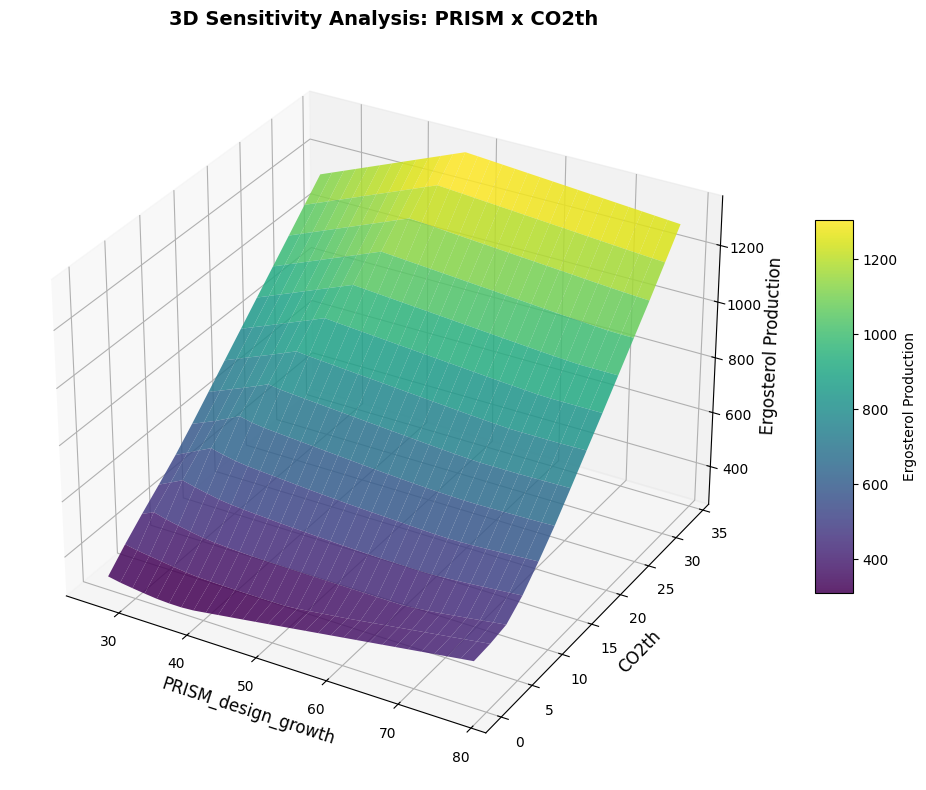

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_surface_from_results(results_dict, x_label='PRISM_design_growth', y_label='CO2th', z_label='Ergosterol Production', title='3D Sensitivity Analysis: PRISM x CO2th'):
    """
    Plots a 3D surface from a nested dictionary of results.
    results_dict: dict[float][float] -> FBA result (with .objective_value)
    """
    # Extract sorted gradients (swap axes)
    y_vals = sorted(results_dict.keys())
    x_vals = sorted(next(iter(results_dict.values())).keys())
    
    # Build Z matrix (swap axes)
    Z = np.zeros((len(x_vals), len(y_vals)))
    for i, x in enumerate(x_vals):
        for j, y in enumerate(y_vals):
            fba_result = results_dict[y][x]
            if fba_result is not None and hasattr(fba_result, 'objective_value'):
                Z[i, j] = fba_result.objective_value
            else:
                Z[i, j] = 0
    X, Y = np.meshgrid(x_vals, y_vals, indexing='ij')
    
    # Plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.85)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_zlabel(z_label, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    fig.colorbar(surf, shrink=0.5, aspect=10, label=z_label)
    plt.tight_layout()

    save_path = os.path.join('..','results','bench','sensitivity')
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(os.path.join(save_path, f'3D_CO2th_PRISM.png'), dpi=300, bbox_inches='tight')

    plt.show()

# Visualize the 3D experiment results
plot_3d_surface_from_results(results_CO2th_PRISM)